# Injury Prediction Model Data Preparation

### This file outlines each step of data preparation, including loading data, feature selection, class imbalance check, scaling, and encoding in preparation for model training.

### Data Loading

In [34]:
# Import pandas for data manipulation
import pandas as pd
from sklearn.model_selection import train_test_split

# Load train and test datasets
train_data = pd.read_csv('../Data/Cleaned Data/train.csv')
test_data = pd.read_csv('../Data/Cleaned Data/test.csv')

# Confirm data shapes
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)


Train Data Shape: (2519, 52)
Test Data Shape: (85, 52)


Starting feature selection analysis...


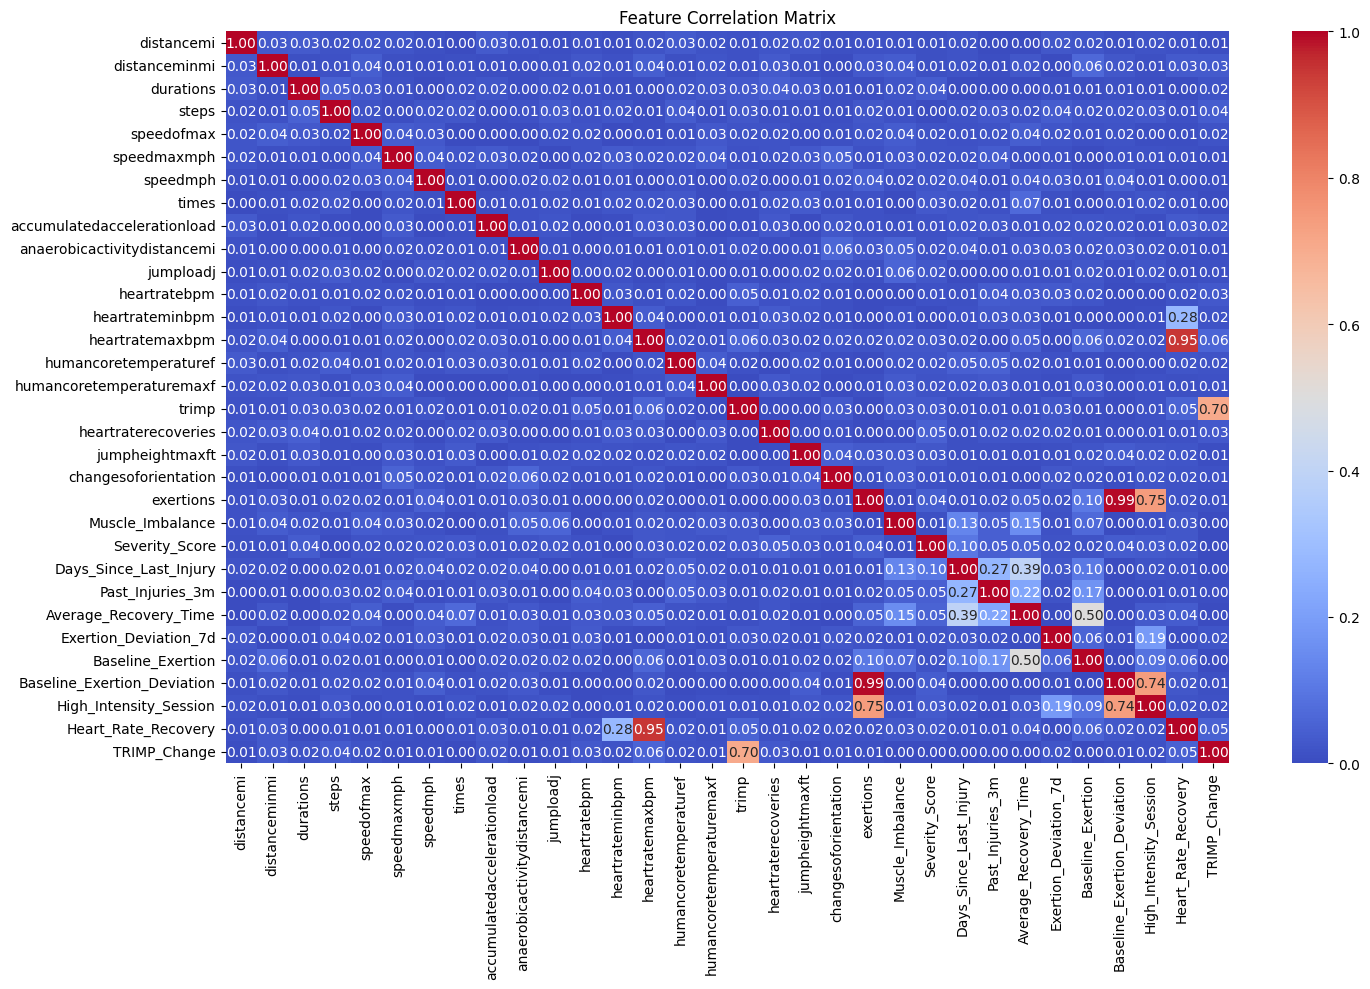


Highly correlated feature pairs (correlation >= 0.8):
heartratemaxbpm - Heart_Rate_Recovery: 0.949
exertions - Baseline_Exertion_Deviation: 0.994

1. Mutual Information Selection:
                        Feature  MI_Score
21             Muscle_Imbalance  0.065789
22               Severity_Score  0.045664
23       Days_Since_Last_Injury  0.018681
27            Baseline_Exertion  0.015897
25        Average_Recovery_Time  0.015587
0                    distancemi  0.005738
15     humancoretemperaturemaxf  0.004624
20                    exertions  0.004550
2                     durations  0.003939
11                 heartratebpm  0.003273
1                 distanceminmi  0.002921
8   accumulatedaccelerationload  0.002462
4                    speedofmax  0.002085
31                 TRIMP_Change  0.001067
7                         times  0.001040
16                        trimp  0.000587
28  Baseline_Exertion_Deviation  0.000420
24             Past_Injuries_3m  0.000064
12              heart

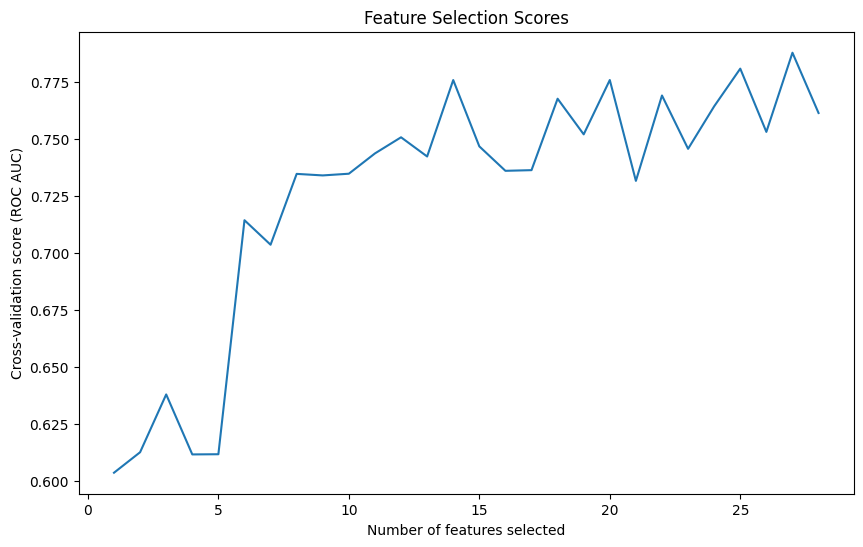


Optimal number of features: 31
                        Feature  Selected  Ranking
0                    distancemi      True        1
1                 distanceminmi      True        1
2                     durations      True        1
3                         steps      True        1
4                    speedofmax      True        1
5                   speedmaxmph      True        1
6                      speedmph      True        1
7                         times      True        1
8   accumulatedaccelerationload      True        1
9   anaerobicactivitydistancemi      True        1
10                    jumploadj      True        1
11                 heartratebpm      True        1
12              heartrateminbpm      True        1
13              heartratemaxbpm      True        1
14        humancoretemperaturef      True        1
15     humancoretemperaturemaxf      True        1
16                        trimp      True        1
17          heartraterecoveries      True        1

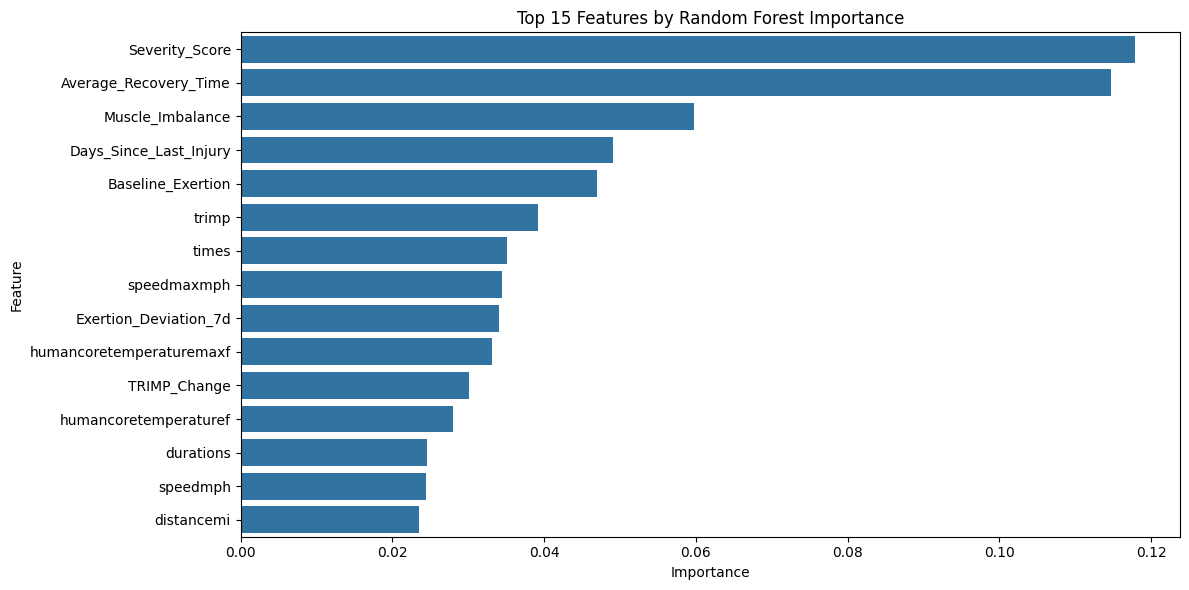


Final Feature Rankings:
                        Feature  MI_Score  RF_Importance  RFE_Selected  \
22               Severity_Score  0.694095       1.000000          True   
21             Muscle_Imbalance  1.000000       0.499408          True   
25        Average_Recovery_Time  0.236932       0.972385          True   
23       Days_Since_Last_Injury  0.283946       0.407467          True   
27            Baseline_Exertion  0.241642       0.388527          True   
15     humancoretemperaturemaxf  0.070281       0.269275          True   
16                        trimp  0.008921       0.322403          True   
7                         times  0.015801       0.286462          True   
5                   speedmaxmph  0.000000       0.281348          True   
26        Exertion_Deviation_7d  0.000000       0.277466          True   
0                    distancemi  0.087217       0.186433          True   
31                 TRIMP_Change  0.016225       0.243341          True   
2            

In [37]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV

# Load the train dataset
#train_data = pd.read_csv('train.csv')

# Define features and target
features_to_use = ['distancemi', 'distanceminmi', 'durations',
       'steps', 'speedofmax', 'speedmaxmph', 'speedmph', 'times',
       'accumulatedaccelerationload', 'anaerobicactivitydistancemi',
       'jumploadj', 'heartratebpm', 'heartrateminbpm', 'heartratemaxbpm',
       'humancoretemperaturef', 'humancoretemperaturemaxf', 'trimp',
       'heartraterecoveries', 'jumpheightmaxft', 'changesoforientation',
       'exertions','Muscle_Imbalance', 'Severity_Score',
       'Days_Since_Last_Injury', 'Past_Injuries_3m', 'Average_Recovery_Time',
       'Exertion_Deviation_7d', 'Baseline_Exertion',
       'Baseline_Exertion_Deviation', 'High_Intensity_Session',
       'Heart_Rate_Recovery', 'TRIMP_Change'
]

X = train_data[features_to_use]
y = train_data['Risk_Label']

# Step 1: Check for correlations
def plot_correlation_matrix(X, threshold=0.8):
    corr_matrix = X.corr().abs()
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated features
    high_corr_features = np.where(corr_matrix >= threshold)
    high_corr_features = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                         for x, y in zip(*high_corr_features) if x != y and x < y]
    if high_corr_features:
        print("\nHighly correlated feature pairs (correlation >= {}):".format(threshold))
        for feat1, feat2, corr in high_corr_features:
            print(f"{feat1} - {feat2}: {corr:.3f}")
    return high_corr_features

# Step 2: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Step 3: Multiple feature selection methods
def select_features():
    # Method 1: Mutual Information
    print("\n1. Mutual Information Selection:")
    mi_selector = SelectKBest(mutual_info_classif, k=10)
    mi_selector.fit(X_scaled, y)
    mi_scores = pd.DataFrame({
        'Feature': features_to_use,
        'MI_Score': mi_selector.scores_
    }).sort_values('MI_Score', ascending=False)
    print(mi_scores)
    
    # Method 2: RFECV (RFE with cross-validation)
    print("\n2. Recursive Feature Elimination with Cross-Validation:")
    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rfecv = RFECV(
        estimator=rf,
        step=1,
        cv=5,
        scoring='roc_auc',
        min_features_to_select=5,
        n_jobs=-1
    )
    rfecv.fit(X_scaled, y)
    
    # Plot number of features vs CV scores using cv_results_
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
             rfecv.cv_results_['mean_test_score'])
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross-validation score (ROC AUC)')
    plt.title('Feature Selection Scores')
    plt.show()
    
    rfe_scores = pd.DataFrame({
        'Feature': features_to_use,
        'Selected': rfecv.support_,
        'Ranking': rfecv.ranking_
    }).sort_values('Ranking')
    print("\nOptimal number of features:", rfecv.n_features_)
    print(rfe_scores)
    
    # Method 3: Random Forest Feature Importance
    print("\n3. Random Forest Feature Importance:")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_model.fit(X_scaled, y)
    
    rf_importance = pd.DataFrame({
        'Feature': features_to_use,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    print(rf_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=rf_importance.head(15), x='Importance', y='Feature')
    plt.title('Top 15 Features by Random Forest Importance')
    plt.tight_layout()
    plt.show()
    
    return mi_scores, rfe_scores, rf_importance

# Step 4: Combine and analyze results
def get_final_features(mi_scores, rfe_scores, rf_importance, n_features=10):
    # Normalize scores
    mi_norm = mi_scores.copy()
    mi_norm['MI_Score'] = (mi_norm['MI_Score'] - mi_norm['MI_Score'].min()) / \
                         (mi_norm['MI_Score'].max() - mi_norm['MI_Score'].min())
    
    rf_norm = rf_importance.copy()
    rf_norm['Importance'] = (rf_norm['Importance'] - rf_norm['Importance'].min()) / \
                           (rf_norm['Importance'].max() - rf_norm['Importance'].min())
    
    # Combine scores
    final_scores = pd.DataFrame({
        'Feature': features_to_use,
        'MI_Score': mi_norm['MI_Score'],
        'RF_Importance': rf_norm['Importance'],
        'RFE_Selected': rfe_scores['Selected']
    })
    
    # Calculate combined score
    final_scores['Combined_Score'] = (
        final_scores['MI_Score'] * 0.3 + 
        final_scores['RF_Importance'] * 0.3 + 
        final_scores['RFE_Selected'].astype(float) * 0.4
    )
    
    final_scores = final_scores.sort_values('Combined_Score', ascending=False)
    
    print("\nFinal Feature Rankings:")
    print(final_scores)
    
    selected_features = final_scores.head(n_features)['Feature'].tolist()
    return selected_features

# Validate feature selection
def validate_feature_selection(selected_features):
    X_selected = X_scaled[selected_features]
    rf_validator = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    
    # Compare performance with all features vs selected features
    cv_scores_all = cross_val_score(rf_validator, X_scaled, y, cv=5, scoring='roc_auc')
    cv_scores_selected = cross_val_score(rf_validator, X_selected, y, cv=5, scoring='roc_auc')
    
    print("\nValidation Results:")
    print(f"All features - Mean ROC-AUC: {cv_scores_all.mean():.3f} (+/- {cv_scores_all.std() * 2:.3f})")
    print(f"Selected features - Mean ROC-AUC: {cv_scores_selected.mean():.3f} (+/- {cv_scores_selected.std() * 2:.3f})")

# Run the analysis
print("Starting feature selection analysis...")
high_corr_features = plot_correlation_matrix(X, threshold=0.8)
mi_scores, rfe_scores, rf_importance = select_features()
final_features = get_final_features(mi_scores, rfe_scores, rf_importance)

print("\nFinal Selected Features:")
print(final_features)

validate_feature_selection(final_features)

In [38]:
final_features

['Severity_Score',
 'Muscle_Imbalance',
 'Average_Recovery_Time',
 'Days_Since_Last_Injury',
 'Baseline_Exertion',
 'humancoretemperaturemaxf',
 'trimp',
 'times',
 'speedmaxmph',
 'Exertion_Deviation_7d']

### Feature Selection

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.calibration import calibration_curve

class RobustInjuryModel:
    def __init__(self):
        self.features = [
            'Average_Recovery_Time',
            'Severity_Score',
            'Baseline_Exertion',
            'Muscle_Imbalance',
            'trimp',
            'Days_Since_Last_Injury'
        ]
        self.target = 'Risk_Label'
        self.best_model = None
        self.scaler = RobustScaler()

    def create_pipeline(self, model_type='rf'):
        # Much stronger regularization parameters
        if model_type == 'rf':
            model = RandomForestClassifier(
                random_state=42,
                class_weight='balanced_subsample',
                n_jobs=-1
            )
            param_grid = {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [2, 3],  # Reduced max_depth
                'classifier__min_samples_split': [15, 20],  # Increased min_samples_split
                'classifier__min_samples_leaf': [10, 15],  # Increased min_samples_leaf
                'classifier__max_features': ['sqrt'],  # Limited feature selection
                'smote_tomek__sampling_strategy': [0.1, 0.2]  # Reduced synthetic sampling
            }
        
        elif model_type == 'gb':
            model = GradientBoostingClassifier(
                random_state=42
            )
            param_grid = {
                'classifier__n_estimators': [50, 100],
                'classifier__learning_rate': [0.01],  # Smaller learning rate
                'classifier__max_depth': [2],  # Reduced depth
                'classifier__min_samples_leaf': [15],
                'classifier__subsample': [0.7],
                'smote_tomek__sampling_strategy': [0.1, 0.2]
            }
        
        elif model_type == 'lr':
            model = LogisticRegression(
                random_state=42,
                max_iter=2000
            )
            param_grid = {
                'classifier__C': [0.001, 0.01],  # Stronger regularization
                'classifier__penalty': ['l2'],
                'classifier__class_weight': ['balanced'],
                'smote_tomek__sampling_strategy': [0.1, 0.2]
            }

        pipeline = Pipeline([
            ('scaler', self.scaler),
            ('smote_tomek', SMOTETomek(random_state=42)),
            ('classifier', model)
        ])

        return pipeline, param_grid

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        # Use repeated stratified k-fold for more robust validation
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
        results = {}
        
        for model_type in ['rf', 'gb', 'lr']:
            print(f"\nTraining {model_type.upper()}...")
            pipeline, param_grid = self.create_pipeline(model_type)
            
            # Grid search with repeated cross-validation
            grid_search = GridSearchCV(
                pipeline,
                param_grid,
                cv=cv,
                scoring='roc_auc',
                n_jobs=-1,
                verbose=1
            )
            
            # Fit model
            grid_search.fit(X_train, y_train)
            
            # Get predictions
            y_pred = grid_search.predict(X_test)
            y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
            
            # Cross-validation predictions
            cv_pred_proba = cross_val_predict(
                grid_search.best_estimator_,
                X_train,
                y_train,
                cv=cv,
                method='predict_proba'
            )
            
            # Calculate metrics
            cv_roc_auc = roc_auc_score(y_train, cv_pred_proba[:, 1])
            test_roc_auc = roc_auc_score(y_test, y_pred_proba)
            
            results[model_type] = {
                'model': grid_search.best_estimator_,
                'cv_roc_auc': cv_roc_auc,
                'test_roc_auc': test_roc_auc,
                'predictions': y_pred,
                'probabilities': y_pred_proba,
                'best_params': grid_search.best_params_
            }
            
            # Print detailed results
            print(f"\nBest parameters: {grid_search.best_params_}")
            print(f"CV ROC-AUC: {cv_roc_auc:.3f}")
            print(f"Test ROC-AUC: {test_roc_auc:.3f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))
            print("\nConfusion Matrix:")
            print(confusion_matrix(y_test, y_pred))
            
            # Plot calibration curve
            self._plot_calibration_curve(y_test, y_pred_proba, model_type)
            
        # Compare models
        self._plot_model_comparison(results)
        
        # Select best model
        best_model_type = max(results.items(), key=lambda x: x[1]['cv_roc_auc'])[0]
        self.best_model = results[best_model_type]['model']
        
        return results

    def _plot_calibration_curve(self, y_true, y_prob, model_type):
        """Plot calibration curve for model predictions"""
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=5)
        plt.figure(figsize=(8, 6))
        plt.plot(prob_pred, prob_true, marker='o', label=f'Calibration curve')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal')
        plt.xlabel('Mean predicted probability')
        plt.ylabel('True probability')
        plt.title(f'Calibration Curve - {model_type.upper()}')
        plt.legend()
        plt.grid(True)
        plt.show()

    def _plot_model_comparison(self, results):
        models = list(results.keys())
        cv_scores = [results[m]['cv_roc_auc'] for m in models]
        test_scores = [results[m]['test_roc_auc'] for m in models]
        
        plt.figure(figsize=(10, 6))
        width = 0.35
        x = np.arange(len(models))
        
        plt.bar(x - width/2, cv_scores, width, label='CV ROC-AUC')
        plt.bar(x + width/2, test_scores, width, label='Test ROC-AUC')
        
        plt.xlabel('Models')
        plt.ylabel('ROC-AUC Score')
        plt.title('Model Performance Comparison')
        plt.xticks(x, models)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def predict_risk(self, new_data, threshold=0.5):
        if self.best_model is None:
            raise ValueError("Model has not been trained yet")
            
        probabilities = self.best_model.predict_proba(new_data[self.features])[:, 1]
        
        # Conservative risk levels
        risk_levels = pd.cut(
            probabilities,
            bins=[0, 0.3, 0.5, 0.7, 0.85, 1],
            labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High']
        )
        
        return pd.DataFrame({
            'probability': probabilities,
            'risk_level': risk_levels,
            'confidence': np.abs(probabilities - 0.5) * 2,
            'prediction': (probabilities > threshold).astype(int)
        })

def main():
    model = RobustInjuryModel()
    
    # Load data
    # train_data = pd.read_csv('train.csv')
    # test_data = pd.read_csv('test.csv')
    
    X_train = train_data[model.features]
    y_train = train_data[model.target]
    X_test = test_data[model.features]
    y_test = test_data[model.target]
    
    print("Class distribution:")
    print(pd.value_counts(y_train, normalize=True))
    
    # Train and evaluate
    results = model.train_and_evaluate(X_train, y_train, X_test, y_test)
    
    # Make predictions
    predictions = model.predict_risk(X_test)
    print("\nExample predictions:")
    print(predictions.head())

if __name__ == "__main__":
    main()

Class distribution:
Risk_Label
0    0.971814
1    0.028186
Name: proportion, dtype: float64

Training RF...
Fitting 15 folds for each of 32 candidates, totalling 480 fits


/tmp/ipykernel_25401/12847044.py:215: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(y_train, normalize=True))


ValueError: cross_val_predict only works for partitions